# Setup and Installation

Within this Jupyter notebook we will use **AI as a service** and try an existing service for vision detection. As an example we will use Google's Cloud Vision API.

Google Cloud Vision provides **capabilities for vision detection** through **pre-trained ML models**, including image labeling, face and landmark detection, text detection, and tagging of explicit content. To enable easy integration of these capabilities in your application Google Cloud Vision provides a **REST API** and **client libraries** in different programming languages such as Python.


In [ ]:
# Install the Google Cloud Vision library that allows us to make request to the Google Cloud Vision API
!pip install google-cloud-vision

In [ ]:
# Import the libraries
from google.cloud import vision
import os
import json

To use the Google Vision API you require **access keys**. The access keys contain authorization information for using the API, but no identity information. Each time you want to make a call to Google's Cloud Vision API an access key needs to be provided (in form of a JSON file) which is then used to authenticate and provide authorization information to Google.

**Get your private key file.** For the sake of this tutorial session you can download the JSON file with the private key information from Canvas. If you want to continue using this notebook after the course, you can set up the Vision API for yourself and create your own service account keys (https://cloud.google.com/vision/docs/setup).

**Copy the content of the private key file into the cell below.**



In [ ]:
credentials = {
##COPY the content of the JSON file here##

}

json_credentials = json.dumps(credentials)

with open('My Project-543e6ed386ee.json','w') as outfile:
  outfile.write(json_credentials)

In [ ]:
# Using the GOOGLE_APPLICATION_CREDENTIALS environment variable the location of a credential JSON file can be provided.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'My Project-543e6ed386ee.json'

# Using Google's Vision API

Google's [Cloud Vision API](https://cloud.google.com/vision/docs) provides different vision detection capabilities via a **single endpoint** that supports the annotation of images.

In [ ]:
# Instantiate the client (this only works with the credantials correctly set)
client = vision.ImageAnnotatorClient()

Each request to the API requires an **image**. One way to provide the image is by specifying the image URI. This can either be a publicly-accessible HTTP or HTTPS URL or a Cloud Storage URI.

In [ ]:
# Here we use a publicly-accessible URL as image URI
# Before making the request we open the image via its uri and display it
from PIL import Image
import urllib.request

uri = 'https://www.indiewire.com/wp-content/uploads/2016/08/20140216-131646.jpg'
#uri = 'https://cdn.qwiklabs.com/5%2FxwpTRxehGuIRhCz3exglbWOzueKIPikyYj0Rx82L0%3D'

with urllib.request.urlopen(uri) as url:
    img=Image.open(url)
    display(img)

Initialize the image and pass the URI as the value of `image.source.image_uri`.

In [ ]:
# Set image to be analyzed by Google Vision
image = vision.Image()
image.source.image_uri=uri

## Face Detection

A request to the API additionally requires an indication concerning the **types of annotations** to be performed on the image.

For example, `client.face_detection(image=image)` can be used to use the capability of **detecting faces** in images. For a more comprehensive overview of supported feature types see https://cloud.google.com/vision/docs/features-list.

The **face_detection** feature
*   locates faces with bounding polygons,
*   identifies specific facial "landmarks" such as eyes, ears, nose, mouth

along with their corresponding confidence values.

Moreover it returns
* likelihood ratings for emotion (joy, sorrow, anger, surprise) and
* general image properties (underexposed, blurred, headwear present).

Likelihoods ratings are expressed as 6 different values: UNKNOWN, VERY_UNLIKELY, UNLIKELY, POSSIBLE, LIKELY, or VERY_LIKELY.

The API provides this information in the response object which is represented in JSON format. The response can be stored in a variable, e.g., `response_faces` to access the above information.

In [ ]:
#### FACE DETECTION ######
## Use the face detection feature of the Google Cloud API and store the result
response_faces = client.face_detection(image=image)

Let us now inspect the JSON response.

In [ ]:
##Show the JSON response
print(response_faces)

Since the JSON response provides more information than what we actually need we can further process the response and only extract the data we are interested in.

**How to access a face?**
The JSON response can potentially contain more than one face. With `response_faces.face_annotations` we can access the different faces and use a loop `for face in response_faces.face_annotations:` to iterate over the different faces. With `response_faces.face_annotations[0]` we can access the first face.

**How to access the properties of a single face?**
This then allows us to access the properties of each of the faces. For example, `face.surprise_likelihood ` gives us the surprise likelihood of a particular face.


### Extracting Face Properties

In [ ]:
for face in response_faces.face_annotations:
    print(face.surprise_likelihood)

Likelihood.VERY_UNLIKELY


To make the output look a bit more user-friendly and only show the likelihood name we make a small change to the code.

In [ ]:
# Names of likelihood from google.cloud.vision.enums
likelihood_name = ('UNKNOWN', 'VERY_UNLIKELY', 'UNLIKELY', 'POSSIBLE',
                       'LIKELY', 'VERY_LIKELY')

for face in response_faces.face_annotations:
    print(likelihood_name[face.surprise_likelihood])

VERY_UNLIKELY



Let us now create a string with information concerning all emotion likelihood ratings. For this, wedefine a function called `hasEmotions(face)` which returns for a given face a string with the likelihood ratings for the different emotions (e.g., `Joy: VERY_LIKELY; Sorrow: VERY_UNLIKELY; Anger: VERY_UNLIKELY; Surprise: VERY_UNLIKELY`).

Moreover, let us define a function called `obtainCharacteristics(face)` which returns for a given face a string with the headware likelihood rating (e.g., `Wearing headware: VERY_LIKELY`).

In [ ]:
# Function to create a string with the likelihood rating for the different emotions
def hasEmotions(face):
      emotionStr = 'Joy: {}; Sorrow: {}; Anger: {}; Surprise: {}'.format(likelihood_name[face.joy_likelihood],
                                                                         likelihood_name[face.sorrow_likelihood],
                                                                         likelihood_name[face.anger_likelihood],
                                                                         likelihood_name[face.surprise_likelihood])
      return emotionStr

# Function to create a string with the headware likelihood rating
def obtainCharacteristics(face):
        fmtstr = 'Wearing headware: {}'.format(likelihood_name[face.headwear_likelihood])
        return fmtstr


Since the response provided by the API can potentially contain several faces the function defined above needs to be call for each face.

In [ ]:
# For each face the emotion and headware wearing likelihoods are shown
for face in response_faces.face_annotations:
   print(hasEmotions(face))
   print(obtainCharacteristics(face))

Joy: VERY_LIKELY; Sorrow: VERY_UNLIKELY; Anger: VERY_UNLIKELY; Surprise: VERY_UNLIKELY
Wearing headware: VERY_UNLIKELY


In [ ]:
# Show the emotion and headware wearing likelihoods for the first face
face = response_faces.face_annotations[0]
print(hasEmotions(face))
print(obtainCharacteristics(face))

Joy: VERY_LIKELY; Sorrow: VERY_UNLIKELY; Anger: VERY_UNLIKELY; Surprise: VERY_UNLIKELY
Wearing headware: VERY_UNLIKELY


## Label Detection

We already tried the face detection features. Let's now explore some of the other **types of annotations**.

For example, `client.label_detection(image=image)` can be used to use the capability of **detecting labels** in images. For a more comprehensive overview of supported feature types see https://cloud.google.com/vision/docs/features-list.

The `label_detection` feature provides generalized labels for an image.
For each label it returns
* a textual description,
* confidence score,
* and topicality rating.

If you want to use customized labeling you can use [AutoML Vision](https://cloud.google.com/vision/automl/docs) to create a custom machine learning model for your specific use case. You provide a labeled data set and AutoML Vision does the training for you.

In [ ]:
#### LABEL DETECTION ######

response_label = client.label_detection(image=image)
#print(response_label)

for label in response_label.label_annotations:
    print({'label': label.description, 'score': label.score})

{'label': 'Smile', 'score': 0.960986852645874}
{'label': 'Hairstyle', 'score': 0.9509009122848511}
{'label': 'Facial expression', 'score': 0.9326043128967285}
{'label': 'Musician', 'score': 0.9107003211975098}
{'label': 'Flash photography', 'score': 0.8821425437927246}
{'label': 'Bow tie', 'score': 0.8675845265388489}
{'label': 'Coat', 'score': 0.8675010204315186}
{'label': 'Music artist', 'score': 0.8607556819915771}
{'label': 'Entertainment', 'score': 0.857021689414978}
{'label': 'Music', 'score': 0.8426316380500793}


## Landmark Detection

Let's now explore the landmark detection. For this, we need to provide an image that contains a landmark.

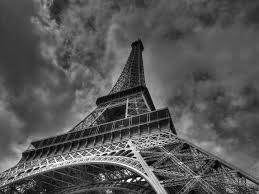

In [ ]:
# Open an image via its uri and display it
from PIL import Image
import urllib.request

uri = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQa-ItjJOrVECuwX-xAtN9rNTuNiHl2aHCeSA&usqp=CAU'
#uri = 'https://img.luzernerzeitung.ch/2020/5/26/fbc87bef-bf45-433b-a7ca-5404a9ef37ea.jpeg?width=560&fit=crop&quality=75&auto=webp'

with urllib.request.urlopen(uri) as url:
    img=Image.open(url)
    display(img)

# Set image to be analyzed by Google Vision
image = vision.Image()
image.source.image_uri=uri

Using `client.landmark_detection(image=image)` can be used to use the capability of detecting landmarks in images.

The `landmark_detection` feature provides
* the name of the landmark, a confidence score and a bounding box in the image for the landmark,
* coordinates for the detected entity.

The JSON response contains landmark_annotations. We can access the details for each of the landmark using a for loop that iterates over the annotations: `for landmark in response_image.landmark_annotations:`.

In [ ]:
#### LANDMARK DETECTION ######

response_image = client.landmark_detection(image=image)
#print(response_image)

for landmark in response_image.landmark_annotations:
    print({'label': landmark.description, 'score': landmark.score})
    for location in landmark.locations:
            lat_lng = location.lat_lng
            print('Latitude {}'.format(lat_lng.latitude))
            print('Longitude {}'.format(lat_lng.longitude))


{'label': 'Champ De Mars', 'score': 0.6176349520683289}
Latitude 48.855647499999996
Longitude 2.2986304
{'label': 'Eiffel Tower', 'score': 0.5595474243164062}
Latitude 48.858370099999995
Longitude 2.2944812999999997
{'label': 'Bassins Du Champ De Mars', 'score': 0.5211896896362305}
Latitude 48.856086399999995
Longitude 2.2979138


## Text Detection in Images

Let's now explore optical character recognition (OCR). In particular, `client.text_detection(image=image)` can be used to extract text from images.

The `text_detection` feature provides the entire extracted string, as well as individual words, and their bounding boxes.

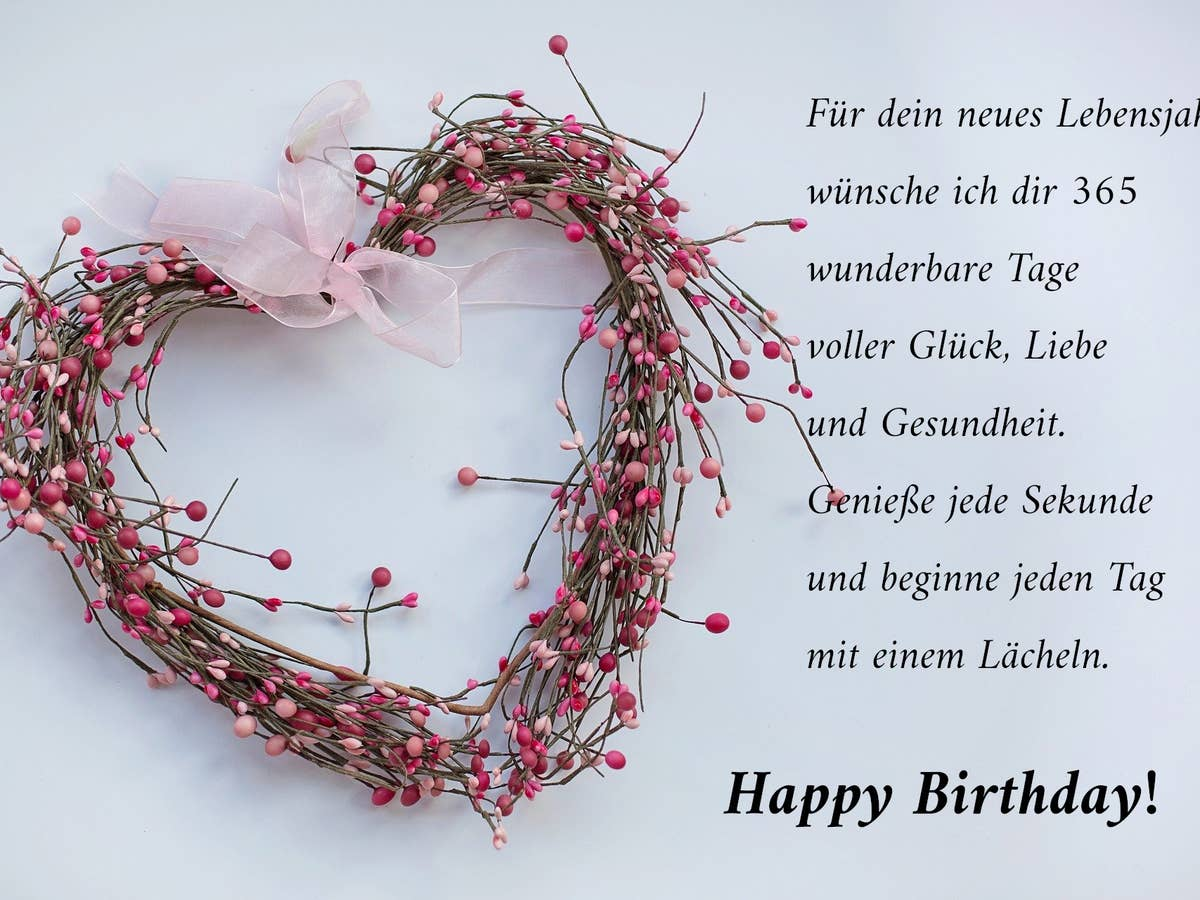

In [ ]:
# Open an image via its uri and display it
from PIL import Image as PillowImage
import urllib.request

uri = 'https://www.inside-digital.de/img/whatsapp-geburtstagssprueche2.jpg?class=1200x900'
#uri = 'https://www.galaxus.ch/im/Files/2/8/7/1/1/2/6/5/959002-H-002.xxl3.jpgexportGa4PCo68TlLe9g?impolicy=ProductTileImage&resizeWidth=648&resizeHeight=486&cropWidth=648&cropHeight=486&resizeType=downsize&quality=high'

with urllib.request.urlopen(uri) as url:
    img=Image.open(url)
    display(img)

# Set image to be analyzed by Google Vision
image = vision.Image()
image.source.image_uri=uri

In [ ]:
#### TEXT DETECTION ######

response_text = client.text_detection(image=image)

text=""
if response_text.text_annotations:
  #Only print the entire text, not the individual fragments
  text = response_text.text_annotations[0].description
print(text)

Für dein neues Lebensja
wünsche ich dir 365
wunderbare Tage
voller Glück, Liebe
und Gesundheit.
Genieße jede Sekunde
und beginne jeden Tag
mit einem Lächeln.
Happy Birthday!
